In [ ]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../../../SCS')
sys.path.append('../../../scripts/')

from seg_utils import bin_2d_data
import pandas as pd
import matplotlib.pyplot as plt
import math
import skimage.io as sio

from paths import get_data_paths

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
data_path = get_data_paths('../../../data_mapping.yml')['mouse_gut']

In [13]:
OUT_FOLDER = data_path / 'seg_method_results' / 'scs'

INPUT_FOLDER = OUT_FOLDER / 'input'
IMG_PATH = INPUT_FOLDER / 'dapi.tif'
BIN_PATH = INPUT_FOLDER / 'bin_df.tsv'

In [14]:
pixel_scale = 0.10896
pixel_step = 10
pixel_step * pixel_scale

1.0896

## Prepare data

In [15]:
df = pd.read_csv(data_path / 'raw_data' / 'molecules.csv')
df.head()

,molecule_id,gene,x_pixel,y_pixel,z_pixel,x_um,y_um,z_um,area,total_magnitude,brightness,qc_score
0,1,Maoa,1705,1271,0.0,-2935.386,-1218.580,2.5,4,420.1126,2.021306,0.954363
1,2,Maoa,1725,1922,0.0,-2933.229,-1147.614,2.5,4,269.5874,1.828640,0.908246
2,3,Maoa,1753,1863,0.0,-2930.104,-1154.062,2.5,5,501.4615,2.001268,0.977219
3,4,Maoa,1760,1865,0.0,-2929.339,-1153.784,2.5,7,639.0364,1.960428,0.991316
4,5,Maoa,1904,794,0.0,-2913.718,-1270.474,2.5,6,519.3154,1.937280,0.983210


In [16]:
dapi_img = sio.imread(data_path / 'raw_data' / 'dapi_stack.tif')

(940, 561)

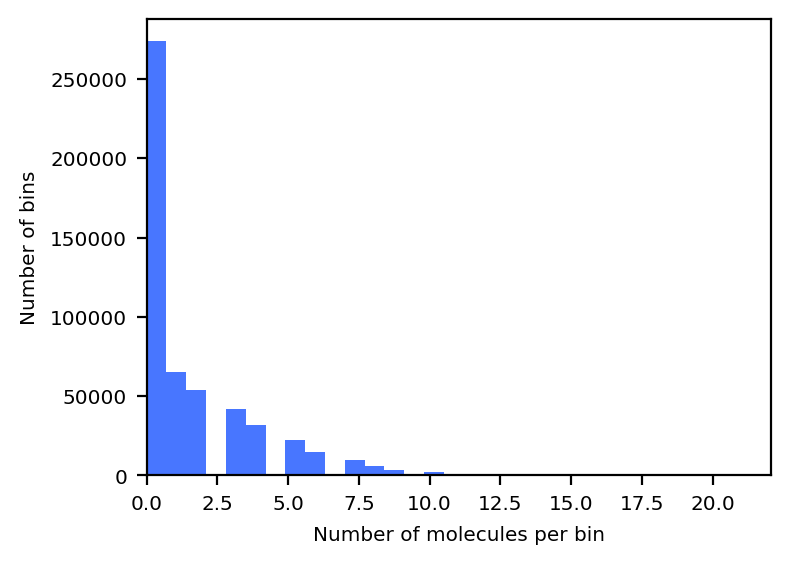

In [17]:
hist_info = bin_2d_data(df['x_pixel'], df['y_pixel'], step=pixel_step)
plt.figure(figsize=(4, 3))
plt.hist(hist_info[0].flatten(), bins=30);
plt.xlabel('Number of molecules per bin'); plt.ylabel('Number of bins');
plt.xlim(0, None);

hist_info[0].shape

In [18]:
df['row'] = hist_info[-2]
df['column'] = hist_info[-1]

df.to_csv(f'{INPUT_FOLDER}/df.csv')

In [19]:
# SCS assume that the data is indexed (x, y), so rows are named `x`
bin_df =(
    df.groupby(['gene', 'row', 'column']).
    size().
    sort_values(ascending=False).
    reset_index().
    rename(columns={0: 'MIDCounts', 'gene': 'gene_ID', 'row': 'y', 'column': 'x'})
)[['gene_ID', 'x', 'y', 'MIDCounts']]

bin_df.head()

,gene_ID,x,y,MIDCounts
0,Acta2,593,81,12
1,Mptx2,400,223,12
2,Acta2,273,133,12
3,Cps1,98,338,12
4,Apob,612,488,11


In [20]:
(bin_df.x.min(), bin_df.x.max()), (bin_df.y.min(), bin_df.y.max())

((0, 939), (0, 560))

In [21]:
sio.imsave(IMG_PATH, dapi_img[4,::pixel_step, ::pixel_step])
bin_df.to_csv(BIN_PATH, index=False, sep='\t')

## Run SCS

In [22]:
from src import preprocessing, transformer, postprocessing
import scanpy as sc

In [ ]:
preprocessing.preprocess(
    BIN_PATH, IMG_PATH, False, None, 0, 0, patchsize=0, bin_size=3,
    n_neighbor=50, watershed_labels=None, out_path=OUT_FOLDER
)

In [ ]:
transformer.train(0, 0, 0, 100, 0.0625, out_path=OUT_FOLDER)

In [ ]:
cell_labels = postprocessing.postprocess(0, 0, 0, 3, 15, out_path=OUT_FOLDER, figsize=(10, 10))
cell_labels.shape

In [ ]:
cell_labels.max()

## Run SCS on CellPose

In [ ]:
from src import preprocessing, transformer, postprocessing
import scanpy as sc

In [ ]:
OUT_FOLDER = data_path / 'seg_method_results' / 'scs_cellpose/'
!mkdir -p $OUT_FOLDER

In [ ]:
dapi_mask = sio.imread(
    data_path / 'data_analysis' / 'cellpose' / 'cell_boundaries' / 'results' / 'cellpose_dapi.tif'
)[4, ::pixel_step, ::pixel_step]

dapi_mask.shape

In [ ]:
preprocessing.preprocess(
    BIN_PATH, IMG_PATH, False, None, 0, 0, patchsize=0, bin_size=3,
    n_neighbor=50, watershed_labels=dapi_mask, out_path=OUT_FOLDER
)

In [ ]:
transformer.train(0, 0, 0, 100, 0.0625, out_path=OUT_FOLDER)

In [ ]:
cell_labels = postprocessing.postprocess(0, 0, 0, 3, 15, out_path=OUT_FOLDER, figsize=(10, 10))
cell_labels.shape

In [ ]:
cell_labels.max()